In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import customize_dataloader as cd

import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import os
import torchvision

import seaborn as sns
from PIL import Image

import numpy as np
from sklearn.cluster import KMeans

import ast
import pickle




c:\Anaconda\envs\curationsystem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print("CUDA is available. GPU(s) found.")
    print("CUDA devices:")
    for i in range(torch.cuda.device_count()):
        print(f"  - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Only CPU is being used.")

CUDA is available. GPU(s) found.
CUDA devices:
  - NVIDIA GeForce RTX 3070 Ti


# Model Architecture

In order to extract the encoder from the Autoencoder I will try to have two separate class to edfine encoder and decoder. Then another class to assemble this structure. As I discuss with professor lot of skip connection mmight be useful for regeneration but this may not necessarily translate into better feature space. so I will use just one skip connection at the start of the decoder this has helped the autoencoder to be good but still don't have too much hint.

In [3]:
class UNetEncoder(nn.Module):
    def __init__(self, kernel, num_filters, num_in_channels=3):
        super(UNetEncoder, self).__init__()
        stride = 2
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.downconv3(x2)
        x_rf = self.rfconv(x3)
        return x1, x2, x3, x_rf


In [4]:
class UNetDecoder_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNetDecoder_simp, self).__init__()
        padding = kernel // 2

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.finalconv = nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x1, x2, x3, x_rf, original_x):
        x_up1 = self.upconv1(x_rf)
        x_up1_skip = torch.cat([x_up1, x2], dim=1)
        x_up2 = self.upconv2(x_up1_skip)
        x_up3 = self.upconv3(x_up2)
        out = self.finalconv(x_up3)
        return out


In [11]:
class UNet_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNet_simp, self).__init__()
        self.encoder = UNetEncoder(kernel, num_filters, num_in_channels)
        self.decoder = UNetDecoder_simp(kernel, num_filters, num_colours, num_in_channels)

    def forward(self, x):
        x1, x2, x3, x_rf = self.encoder(x)
        out = self.decoder(x1, x2, x3, x_rf, x)
        return out


This is one of the instance of the training model. Due to computatioanl limitation minimal hyperparameter tuning was done.
mostly decreasing model complexity to overcome overfitting. 

Loading data...
Beginning training ...
0 tensor(0.0037)


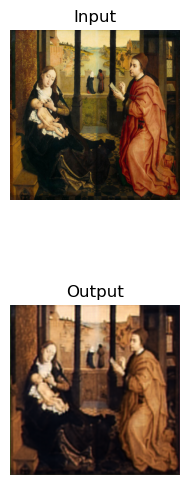

1 tensor(0.0051)


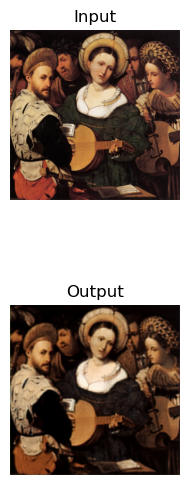

2 tensor(0.0026)


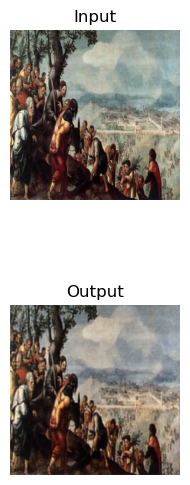

In [ ]:
# Total training time 102min
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet_simp",
    "kernel": 5,
    "num_filters": 10,
    'learn_rate':0.01,
    "batch_size": 64,
    "epochs": 3,
    "seed": 0,
    "resize": transforms.Resize((512,512)),
    "plot": True,
    "experiment_name": "UNet_SEMART",
    "visualize": False,
    "downsize_input": False,
}

# Doing Kmeans Cluster and Save those cluster in separate file

In [ ]:
# large
model = UNet_simp(kernel=3, num_filters=32, num_colours=3, num_in_channels=3)

In [ ]:
# Ensure you're loading the model on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the state dictionary
model_state_dict = torch.load('./outputs/UNet_SEMART/model_epoch_2.pth', map_location=device)

# Update the model with the loaded state dictionary
model.load_state_dict(model_state_dict)
model.cuda()

In [ ]:
raw_dataset, train_loader, val_loader, test_loader,_ = cd.get_data_loader("./SemArt/all_image",batch_size=5,resize=transforms.Resize((224,224)),normailze = True)
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  3422
validation examples:  428
testing examples:  428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

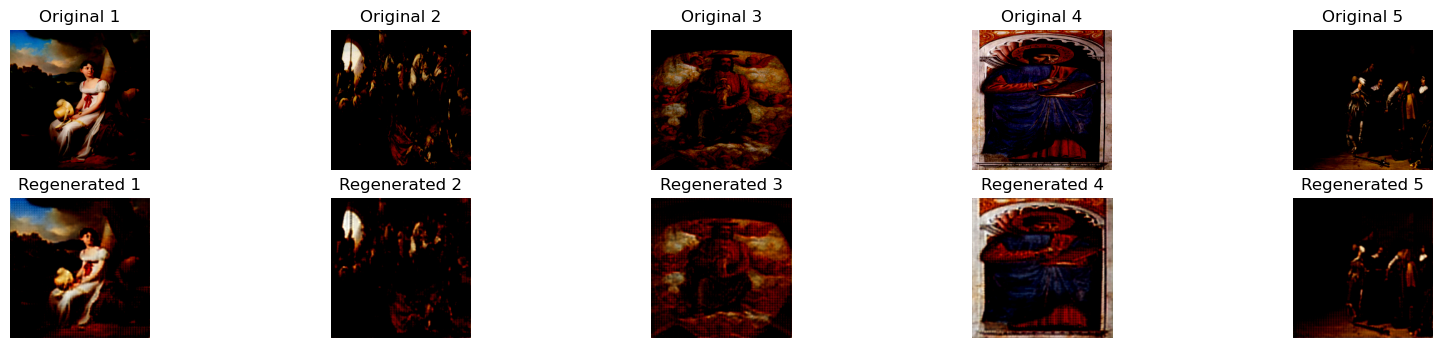

In [ ]:
visualize_reconstructions(model,val_loader)

In [ ]:
encoded_features = []
labels_list = []
file_name_list = [] 

for i, data in enumerate(val_loader, 0):
    inputs, labels, filenames, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l,fn in zip(vec, labels.numpy(),filenames):
        encoded_features.append(v)
        labels_list.append(l)
        file_name_list.append(fn)


In [ ]:
for i, data in enumerate(test_loader, 0):
    inputs, labels, filenames, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l,fn in zip(vec, labels.numpy(),filenames):
        encoded_features.append(v)
        labels_list.append(l)
        file_name_list.append(fn)

In [ ]:
for i, data in enumerate(train_loader, 0):
    inputs, labels, filenames, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l,fn in zip(vec, labels.numpy(),filenames):
        encoded_features.append(v)
        labels_list.append(l)
        file_name_list.append(fn)

In [ ]:
# Create DataFrame
df_embedding = pd.DataFrame({
    'Encoded Features': encoded_features,
    'IMAGE_FILE': file_name_list
})
print(df_embedding.shape)
# Convert the numpy arrays in 'array_column' to tuples
df_embedding.head()

(21384, 2)


Encoded Features          IMAGE_FILE
0  [0.4150609, 0.30639172, 0.38842794, 0.44565457...  35989-sal_1779.jpg
1  [0.61014193, 0.3144976, 0.2744316, 0.33365092,...  09522-christ_a.jpg
2  [0.77301514, 0.7611902, 0.77503455, 0.7475381,...  23879-4manet17.jpg
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  00766-lastjud1.jpg
4  [0.43049988, 0.26010168, 0.2577728, 0.2426328,...  18131-virgin_c.jpg

In [ ]:
df_embedding["Encoded Features"][0]

array([0.4150609 , 0.30639172, 0.38842794, ..., 0.3145883 , 0.2662153 ,
       0.6930831 ], dtype=float32)

In [ ]:
df_embedding["Encoded Features"][0]

array([0.4150609 , 0.30639172, 0.38842794, ..., 0.3145883 , 0.2662153 ,
       0.6930831 ], dtype=float32)

save embeddings

In [ ]:
all_data_df = pd.read_csv('./SemArt/semart_desc_all.csv', sep='\t')
print(all_data_df.shape)
all_data_df.head()

(3207, 9)


IMAGE_FILE                                        DESCRIPTION  \
0  41294-10ladisl.jpg  Of the Hungarian kings St Ladislas is perhaps ...   
1   42791-1sacris.jpg  This ceiling painting in the sacristy of San S...   
2   14376-worship.jpg  In the same period when the most talented arti...   
3  24776-annuncia.jpg  Based on its style the Annunciation is attribu...   
4  23845-3manet04.jpg  The 1870s were rich in female models for Manet...   

                      AUTHOR                             TITLE  \
0  UNKNOWN MASTER, Hungarian  Saint Ladislaus, King of Hungary   
1            VERONESE, Paolo          Coronation of the Virgin   
2         FRANCKEN, Frans II        Worship of the Golden Calf   
3         MASTER of Flémalle                      Annunciation   
4             MANET, Edouard        Brunette with Bare Breasts   

                      TECHNIQUE     DATE       TYPE     SCHOOL  TIMEFRAME  
0   Oil on wood, 103 x 101,3 cm  c. 1600  religious  Hungarian  1551-1600  
1   Oil on canvas, 200 x 170 cm     1555  religious    Italian  1551-1600  
2      Oil on panel, 60 x 88 cm        -  religious    Flemish  1601-1650  
3  Tempera on oak, 61 x 63,7 cm    1420s  religious    Flemish  1401-1450  
4     Oil on canvas, 60 x 49 cm  c. 1872   portrait     French  1851-1900

In [ ]:
#left join
df_joined = all_data_df.merge(df_embedding, on='IMAGE_FILE', how='left')
df_joined.head()

IMAGE_FILE                                        DESCRIPTION  \
0  41294-10ladisl.jpg  Of the Hungarian kings St Ladislas is perhaps ...   
1   42791-1sacris.jpg  This ceiling painting in the sacristy of San S...   
2   14376-worship.jpg  In the same period when the most talented arti...   
3  24776-annuncia.jpg  Based on its style the Annunciation is attribu...   
4  23845-3manet04.jpg  The 1870s were rich in female models for Manet...   

                      AUTHOR                             TITLE  \
0  UNKNOWN MASTER, Hungarian  Saint Ladislaus, King of Hungary   
1            VERONESE, Paolo          Coronation of the Virgin   
2         FRANCKEN, Frans II        Worship of the Golden Calf   
3         MASTER of Flémalle                      Annunciation   
4             MANET, Edouard        Brunette with Bare Breasts   

                      TECHNIQUE     DATE       TYPE     SCHOOL  TIMEFRAME  \
0   Oil on wood, 103 x 101,3 cm  c. 1600  religious  Hungarian  1551-1600   
1   Oil on canvas, 200 x 170 cm     1555  religious    Italian  1551-1600   
2      Oil on panel, 60 x 88 cm        -  religious    Flemish  1601-1650   
3  Tempera on oak, 61 x 63,7 cm    1420s  religious    Flemish  1401-1450   
4     Oil on canvas, 60 x 49 cm  c. 1872   portrait     French  1851-1900   

                                    Encoded Features  
0  [0.66586727, 0.51203525, 0.0, 0.0, 0.0, 0.0, 0...  
1  [0.4588764, 0.31383383, 0.30628043, 0.316805, ...  
2  [0.45856556, 0.32140628, 0.31562173, 0.3044343...  
3  [0.0, 0.0, 0.0, 0.33191314, 0.44521868, 0.7014...  
4  [0.61417955, 0.56172717, 0.60303986, 0.5860305...

In [ ]:
import pickle
# Save the data using pickle
with open('./outputs/encoded_features_desc.pkl', 'wb') as f:
    pickle.dump(df_joined, f)

In [ ]:
#df_joined.to_csv('./outputs/encoded_features_desc.csv')

# Load models

Kmeans, Unet, and embeddings

In [12]:
# Replace 'your_file.pkl' with the path to your pickle file
pickle_file_path = './outputs/encoded_features_desc_w_Cluster_unique.pkl'

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

df_cluster = pd.DataFrame(data)

In [13]:
from joblib import dump, load

# Assuming `kmeans` is your trained KMeans model
model_filename = './outputs/kmeans_model.joblib'
kmeans = load(model_filename)

In [14]:
_, train_loader_wiki, val_loader_wiki, test_loader_wiki, _ = cd.get_data_loader("./wikiART224",resize=transforms.Resize((224,224)),batch_size=1,normailze = True)
print('training examples: ',len(train_loader_wiki))
print('validation examples: ',len(val_loader_wiki))
print('testing examples: ', len(test_loader_wiki))

training examples:  65153
validation examples:  8144
testing examples:  8145


In [15]:
df_cluster

IMAGE_FILE                                        DESCRIPTION  \
0     41294-10ladisl.jpg  Of the Hungarian kings St Ladislas is perhaps ...   
1      42791-1sacris.jpg  This ceiling painting in the sacristy of San S...   
2      14376-worship.jpg  In the same period when the most talented arti...   
3     24776-annuncia.jpg  Based on its style the Annunciation is attribu...   
4     23845-3manet04.jpg  The 1870s were rich in female models for Manet...   
...                  ...                                                ...   
2133    28424-winter.jpg  This signed painting depicts a winter landscap...   
2134    14184-08bolt.jpg  At first sight, this painting describing the f...   
2135  19609-nordlin1.jpg  This is the outside right wing of the high alt...   
2136   35406-08assum.jpg  The Antwerp Cathedral was given a new marble h...   
2137  28428-winterl2.jpg  This painting depicts a winter landscape with ...   

                         AUTHOR                                 TITLE  \
0     UNKNOWN MASTER, Hungarian      Saint Ladislaus, King of Hungary   
1               VERONESE, Paolo              Coronation of the Virgin   
2            FRANCKEN, Frans II            Worship of the Golden Calf   
3            MASTER of Flémalle                          Annunciation   
4                MANET, Edouard            Brunette with Bare Breasts   
...                         ...                                   ...   
2133            MOLENAER, Klaes                      Winter Landscape   
2134     FRAGONARD, Jean-Honoré                              The Bolt   
2135          HERLIN, Friedrich  Family of the Founder Jakob Fuchsart   
2136         RUBENS, Peter Paul              Assumption of the Virgin   
2137            MOLENAER, Klaes                      Winter Landscape   

                         TECHNIQUE     DATE       TYPE     SCHOOL  TIMEFRAME  \
0      Oil on wood, 103 x 101,3 cm  c. 1600  religious  Hungarian  1551-1600   
1      Oil on canvas, 200 x 170 cm     1555  religious    Italian  1551-1600   
2         Oil on panel, 60 x 88 cm        -  religious    Flemish  1601-1650   
3     Tempera on oak, 61 x 63,7 cm    1420s  religious    Flemish  1401-1450   
4        Oil on canvas, 60 x 49 cm  c. 1872   portrait     French  1851-1900   
...                            ...      ...        ...        ...        ...   
2133  Oil on oak panel, 39 x 33 cm        -  landscape      Dutch  1651-1700   
2134     Oil on canvas, 73 x 93 cm  c. 1777      genre     French  1751-1800   
2135              Wood, 89 x 66 cm  1462-65  religious     German  1451-1500   
2136    Oil on panel, 490 x 325 cm     1626  religious    Flemish  1601-1650   
2137  Oil on oak panel, 37 x 49 cm        -  landscape      Dutch  1651-1700   

                                       Encoded Features  Cluster  
0     [0.66586727, 0.51203525, 0.0, 0.0, 0.0, 0.0, 0...        0  
1     [0.4588764, 0.31383383, 0.30628043, 0.316805, ...       10  
2     [0.45856556, 0.32140628, 0.31562173, 0.3044343...       10  
3     [0.0, 0.0, 0.0, 0.33191314, 0.44521868, 0.7014...        6  
4     [0.61417955, 0.56172717, 0.60303986, 0.5860305...        4  
...                                                 ...      ...  
2133  [0.75753313, 0.62387294, 0.5723128, 0.4696973,...        8  
2134  [0.5883344, 0.5935383, 0.6462424, 0.6168197, 0...        5  
2135  [0.5969873, 0.53667825, 0.6016903, 0.6184438, ...       11  
2136  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       19  
2137  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       13  

[2138 rows x 11 columns]

In [18]:
from scipy.spatial.distance import cdist


model_unet = UNet_simp(kernel=3, num_filters=32, num_colours=3, num_in_channels=3)
# Ensure you're loading the model on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the state dictionary
model_state_dict = torch.load('./outputs/UNet_SEMART/model_epoch_2.pth', map_location=device)

# Update the model with the loaded state dictionary
model_unet.load_state_dict(model_state_dict)

<All keys matched successfully>

# Get Helper code

To do this first I have to clusternew image to get the cluster. Get the cluster and compare point within that cluster then get the closest three.

In [19]:
def get_top_similar_file(new_point):
    cluster_label = kmeans.predict(new_point)[0]
    
    # Extract points belonging to the same cluster as the new point
    #same_cluster_indices = np.where(labels == cluster_label)[0]
    same_cluster_df = df_cluster[df_cluster["Cluster"] == cluster_label]
    # Assuming encoded features are stored as lists; convert them to numpy arrays
    cluster_encoded_features = np.stack(same_cluster_df['Encoded Features'].values)

    # Calculate distances from the new point to each point in the same cluster
    distances = cdist(new_point.reshape(1, -1), cluster_encoded_features, metric='cosine').flatten()

    # Get the indices of the top 3 smallest distances
    top_3_indices = distances.argsort()[:3]

    # Retrieve relevant information for the top 3 closest points
    top_3_info = same_cluster_df.iloc[top_3_indices]

    print("Top 3 similar images to the new point are:", top_3_info["IMAGE_FILE"])

    return top_3_info["IMAGE_FILE"],top_3_info

In [20]:
def encode_image(img,model):
    if torch.cuda.is_available():
        inputs = img.cuda()
        model = model.cuda()

    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)

    vec = outputs[-1]  # This selects the last tensor from the tuple
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    return vec

In [21]:
def find_and_display_image(image_file_name, search_directory = "./SemArt/all_image/Images"):
    """
    Searches for an image file in the specified directory and its subdirectories,
    and displays the image if found.
    
    Parameters:
    - image_file_name: The name of the image file to find (e.g., 'example.jpg').
    - search_directory: The root directory to start the search from.
    """
    found = False
    
    # Walk through all directories and files within the search directory
    for root, dirs, files in os.walk(search_directory):
        if image_file_name in files:
            # Construct the full path to the image
            image_path = os.path.join(root, image_file_name)
            print(f"Image found: {image_path}")
            
            # Load and display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.show()
            
            found = True
            break  # Exit the loop once the image is found and displayed
    
    if not found:
        print("Image not found.")

# Using this system

Example of implementation on new data. This autoencoder was trained with semart to get description. So later cell will be showing use cases for the wikiart data. This code below will recommend top 3 image that are similar and its description.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================0=================
Image Input to claude-monet_poplars-on-the-banks-of-the-river-epte-seen-from-the-marsh-1892.jpg


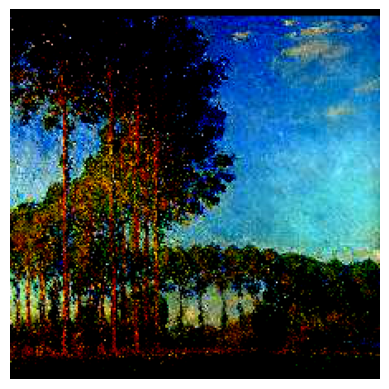

Top 3 similar images to the new point are: 527     04775-landsca2.jpg
169     21079-birchtre.jpg
1728    04486-river_la.jpg
Name: IMAGE_FILE, dtype: object
              IMAGE_FILE                                        DESCRIPTION  \
527   04775-landsca2.jpg  This painting is the pendant of the Landscape ...   
169   21079-birchtre.jpg  Klodt is considered to be a major figure in Ru...   
1728  04486-river_la.jpg  The painting shows a river landscape with fish...   

                              AUTHOR                  TITLE  \
527           BLOEMEN, Jan Frans van      Italian Landscape   
169   KLODT, Mikhail Konstantinovich  Under the Birch Trees   
1728            BEYEREN, Abraham van        River Landscape   

                      TECHNIQUE     DATE       TYPE   SCHOOL  TIMEFRAME  \
527   Oil on canvas, 48 x 38 cm  c. 1735  landscape  Flemish  1651-1700   
169   Oil on canvas, 27 x 48 cm     1874  landscape  Russian  1851-1900   
1728   Oil on panel, 61 x 94 cm        -  landsca

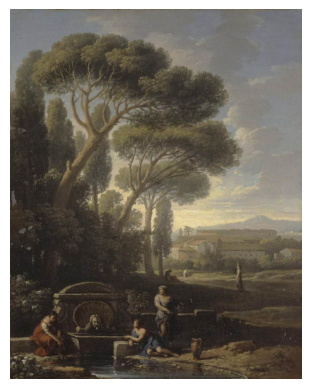

Image found: ./SemArt/all_image/Images\21079-birchtre.jpg


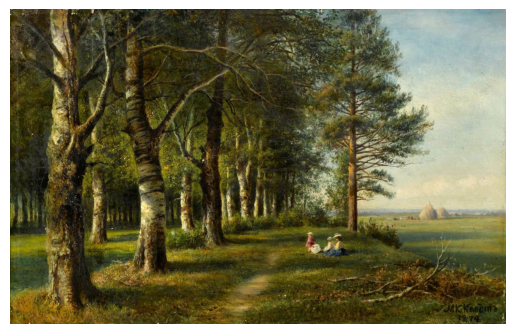

Image found: ./SemArt/all_image/Images\04486-river_la.jpg


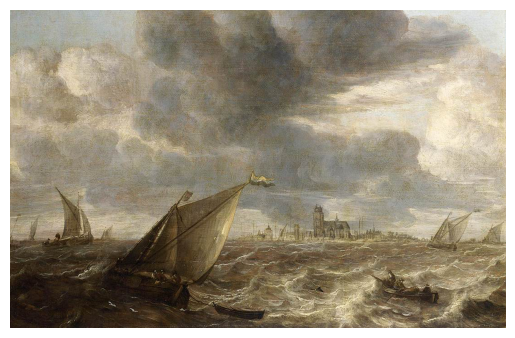

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================1=================
Image Input to gregoire-boonzaier_district-six-1.jpg


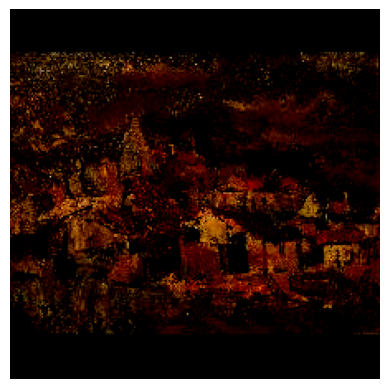

Top 3 similar images to the new point are: 1011    00813-marco_p3.jpg
1630      44746-silver.jpg
264      21928-6carnat.jpg
Name: IMAGE_FILE, dtype: object
              IMAGE_FILE                                        DESCRIPTION  \
1011  00813-marco_p3.jpg  This picture is the second from the left on th...   
1630    44746-silver.jpg  This small painting from Villa Medici in Rome ...   
264    21928-6carnat.jpg  A work that would seem to evoke the sketches o...   

                 AUTHOR                                   TITLE  \
1011      ANGELICO, Fra  Saint Cosmas and Saint Damian Salvaged   
1630     ZUCCHI, Jacopo                           Age of Silver   
264   LEONARDO da Vinci            The Madonna of the Carnation   

                                  TECHNIQUE     DATE          TYPE   SCHOOL  \
1011  Tempera and gold on panel, 38 x 45 cm  1438-40     religious  Italian   
1630                Oil on wood, 50 x 39 cm  c. 1587  mythological  Italian   
264              Oil 

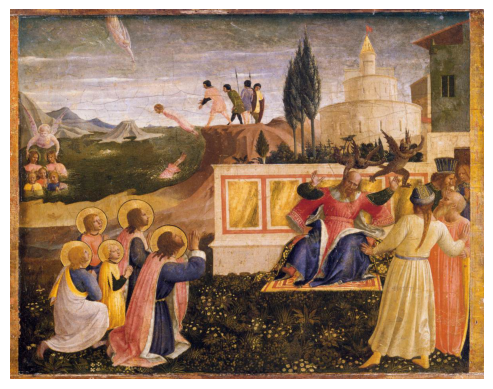

Image found: ./SemArt/all_image/Images\44746-silver.jpg


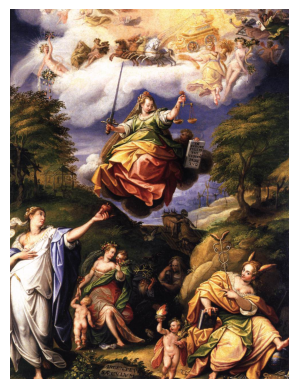

Image found: ./SemArt/all_image/Images\21928-6carnat.jpg


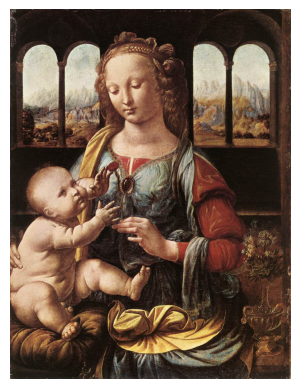

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================2=================
Image Input to ivan-shishkin_forest-stream-2.jpg


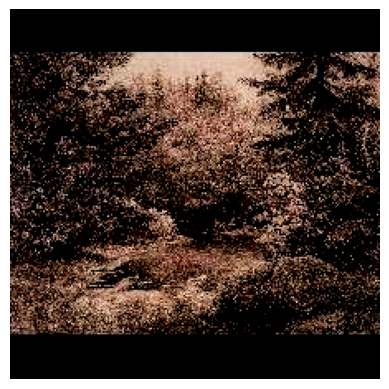

Top 3 similar images to the new point are: 1699    21402-woodedla.jpg
781       28588-paris5.jpg
1227    25344-adoratio.jpg
Name: IMAGE_FILE, dtype: object
              IMAGE_FILE                                        DESCRIPTION  \
1699  21402-woodedla.jpg  The picture shows a wooded landscape with figu...   
781     28588-paris5.jpg  Flags were flown on 30 June, 1878, to mark the...   
1227  25344-adoratio.jpg  In this work by Mazzolino the sharpness of lin...   

                   AUTHOR                                              TITLE  \
1699      LAMBERT, George                                   Wooded Landscape   
781         MONET, Claude  Rue Montorgueil in Paris, Celebration of 30 Ju...   
1227  MAZZOLINO, Ludovico                         Adoration of the Shepherds   

                        TECHNIQUE     DATE        TYPE   SCHOOL  TIMEFRAME  \
1699    Oil on canvas, 52 x 65 cm     1725   landscape  English  1701-1750   
781     Oil on canvas, 81 x 51 cm     1878  histor

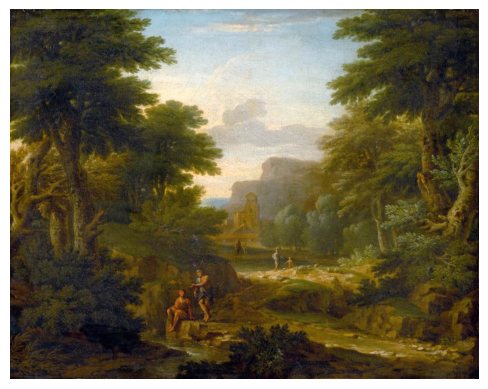

Image found: ./SemArt/all_image/Images\28588-paris5.jpg


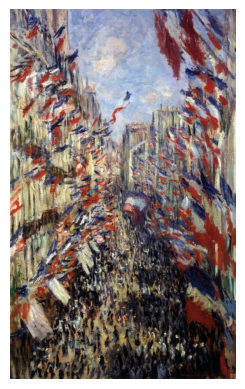

Image found: ./SemArt/all_image/Images\25344-adoratio.jpg


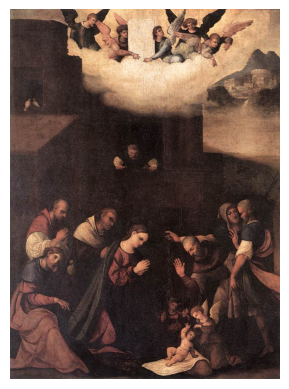

In [26]:
counter = 0
# assuming we only input one Image where batch size  = 1
for images, labels, filenames, sublabels in test_loader_wiki:
    print(f"================{counter}=================")
    print(f"Image Input to {filenames[0]}")
    # Rearrange the axes from (1, 3, 224, 224) to (224, 224, 3)
    img = np.transpose(images, (0, 2, 3, 1)).squeeze(0)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Optionally remove the axis
    plt.show()

    emb = encode_image(images,model_unet)
    top_3_filenames, infos = get_top_similar_file(emb)
    print(infos)
    for fn in top_3_filenames:
        find_and_display_image(fn)
    if counter == 2:
        break
    counter +=1

The model I can say is mixed performance first K means clustering seems to be working great. If you see the top 3 images seem to be very similar so it has captured meaningful things. The autoencoder that embedded the new test data was a bit underperforming but this is understandable since the variation of training data was hugely different and autoencoders do have trouble when they do tasks on unseen data. If the given dataset was large it would be better since, especially for old art pieces overfitting is also more susceptible since there will be no new image created.